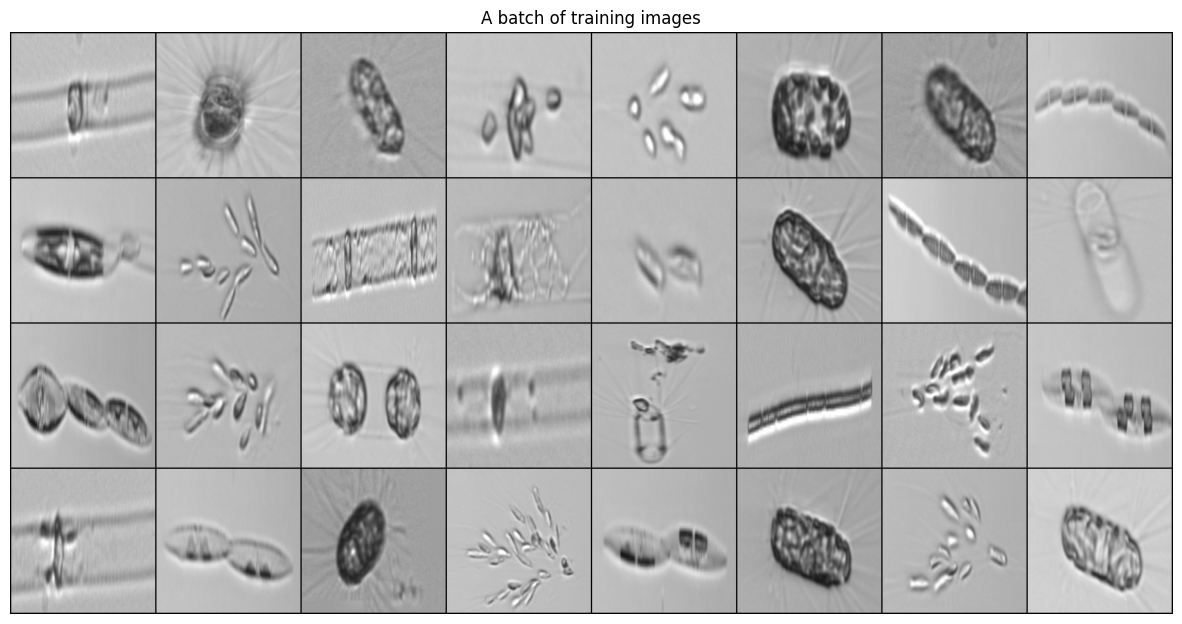

Labels:
['Dactyliosolen', 'Corethron', 'Corethron', 'Dactyliosolen', 'Dinobryon', 'Corethron', 'Corethron', 'Pseudonitzschia', 'Pseudonitzschia', 'Dinobryon', 'Dactyliosolen', 'Dactyliosolen', 'Dinobryon', 'Corethron', 'Pseudonitzschia', 'Corethron', 'Pseudonitzschia', 'Dinobryon', 'Corethron', 'Dactyliosolen', 'Corethron', 'Pseudonitzschia', 'Dinobryon', 'Pseudonitzschia', 'Dactyliosolen', 'Pseudonitzschia', 'Corethron', 'Dinobryon', 'Pseudonitzschia', 'Corethron', 'Dinobryon', 'Corethron']


In [ ]:
import os
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

image_size = 224
batch_size = 32
data_dir = "data"

all_data = datasets.ImageFolder(data_dir)
class_names = all_data.classes

indices = list(range(len(all_data)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[all_data.imgs[i][1] for i in indices], random_state=42)

from torch.utils.data import Subset

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

all_data.transform = train_transforms
train_dataset = Subset(all_data, train_idx)
all_data.transform = val_transforms
val_dataset = Subset(all_data, val_idx)

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Batch visualize
images, labels = next(iter(train_loader))

def show_images(images, labels, class_names):
    # If normalized with mean=0.5, std=0.5 → undo it
    unnorm_images = images * 0.5 + 0.5  # unnormalize to [0,1]
    img_grid = utils.make_grid(unnorm_images, nrow=8)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(img_grid.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title("A batch of training images")
    plt.axis('off')
    plt.show()

    # Optional: Print labels
    print("Labels:")
    print([class_names[i] for i in labels])

show_images(images, labels, class_names)

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC layer
resnet.to(device)
resnet.eval()

def extract_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in tqdm(dataloader):
            imgs = imgs.to(device)
            out = resnet(imgs)  # output shape: [batch, 512, 1, 1]
            out = out.view(out.size(0), -1)  # flatten to [batch, 512]
            features.append(out.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(train_loader)

/Users/jaronchai/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jaronchai/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 54/54 [00:47<00:00,  1.14it/s]


In [36]:
from sklearn.cluster import KMeans

num_clusters = len(class_names)  # or a different value if you want to experiment
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(train_features.numpy())

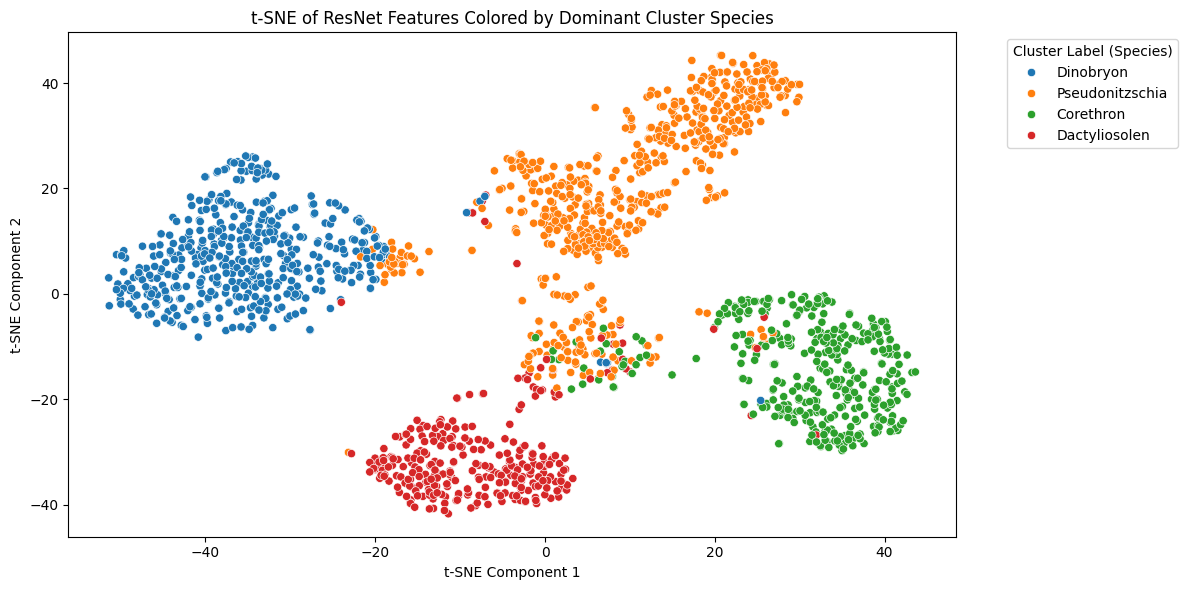

In [37]:
from collections import defaultdict
import numpy as np

# dominant species
cluster_to_label = {}
for cluster in np.unique(cluster_ids):
    # Get true labels for this cluster
    true_labels_in_cluster = train_labels[cluster_ids == cluster]
    if len(true_labels_in_cluster) == 0:
        continue
    most_common = torch.mode(true_labels_in_cluster)[0].item()
    cluster_to_label[cluster] = class_names[most_common]

df["cluster_species"] = [cluster_to_label[c] for c in cluster_ids]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="x", y="y",
    hue="cluster_species",
    palette="tab10",  # Adjust as needed if >10 species
    legend="full"
)
plt.title("t-SNE of ResNet Features Colored by Dominant Cluster Species")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster Label (Species)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(train_labels.numpy(), cluster_ids)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Adjusted Rand Index (ARI): 0.7307


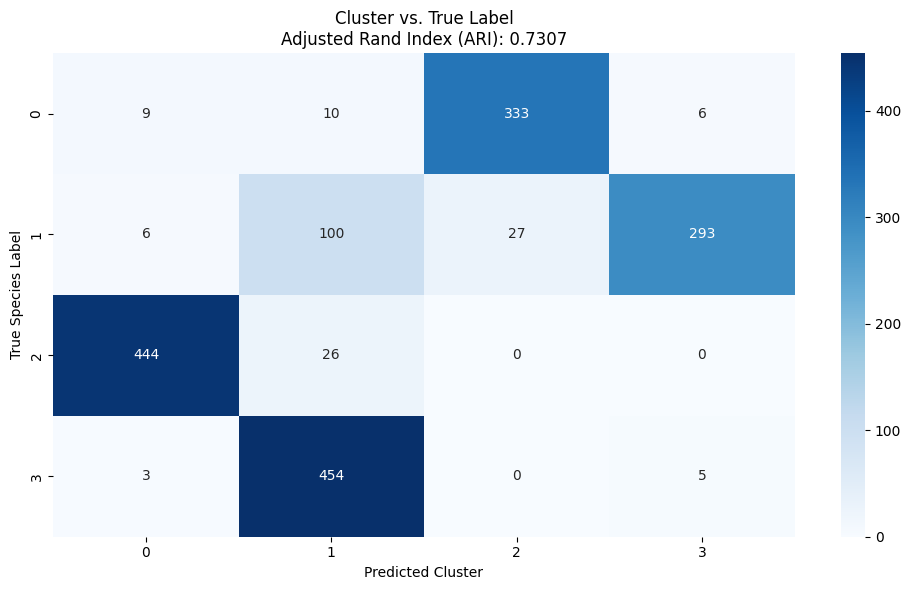

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

confusion_df = pd.crosstab(
    pd.Series(train_labels.numpy(), name="True Label"),
    pd.Series(cluster_ids, name="Predicted Cluster")
)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"Cluster vs. True Label\nAdjusted Rand Index (ARI): {ari:.4f}")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Species Label")
plt.tight_layout()
plt.show()


Adjusted Rand Index (ARI): 0.7307


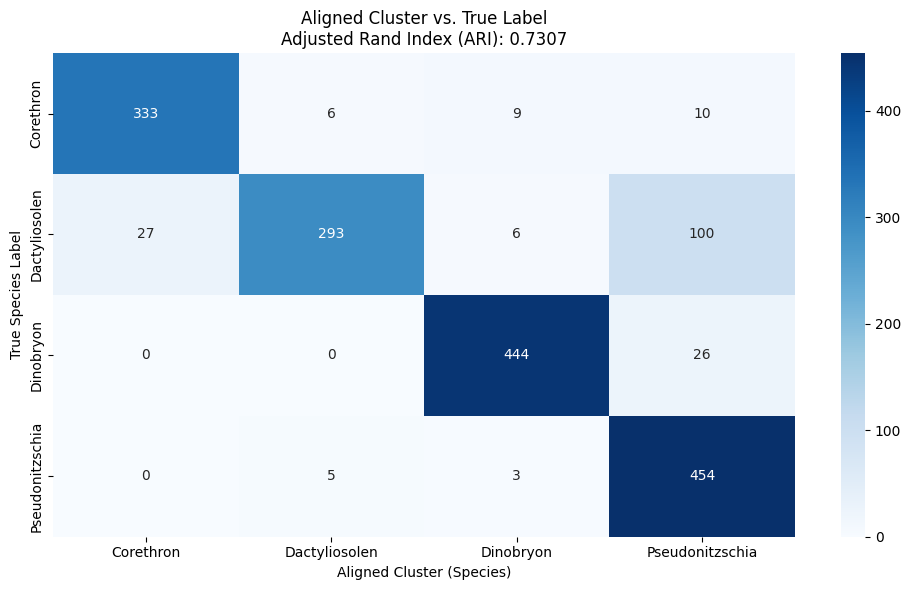

In [ ]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(train_labels, cluster_ids)

# Hungarian algorithm s
row_ind, col_ind = linear_sum_assignment(-cm)  # negate to maximize matching

# Map and Remap
cluster_to_label_map = dict(zip(col_ind, row_ind))
aligned_cluster_ids = np.array([cluster_to_label_map[c] for c in cluster_ids])
ari_aligned = adjusted_rand_score(train_labels, aligned_cluster_ids)
print(f"Adjusted Rand Index (ARI): {ari_aligned:.4f}")

true_label_names = [class_names[i] for i in train_labels]
aligned_cluster_names = [class_names[i] for i in aligned_cluster_ids]
confusion_df = pd.crosstab(
    pd.Series(true_label_names, name="True Species Label"),
    pd.Series(aligned_cluster_names, name="Aligned Cluster (Species)")
)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"Aligned Cluster vs. True Label\nAdjusted Rand Index (ARI): {ari_aligned:.4f}")
plt.xlabel("Aligned Cluster (Species)")
plt.ylabel("True Species Label")
plt.tight_layout()
plt.show()


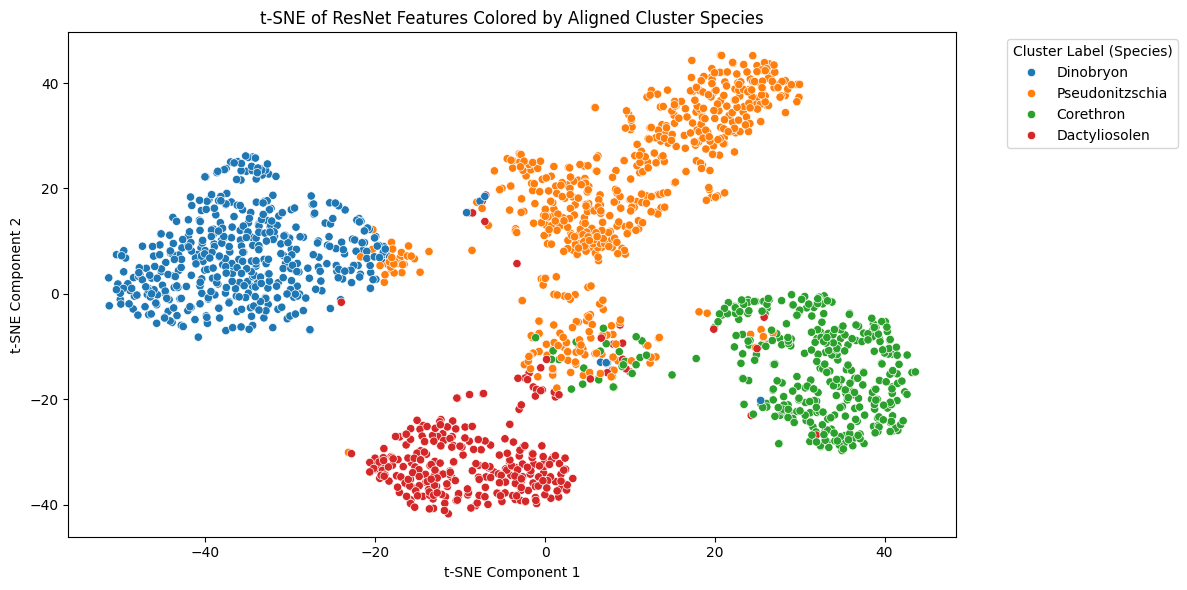

In [ ]:
aligned_cluster_to_label = {}
for aligned_cluster in np.unique(aligned_cluster_ids):
    true_labels_in_cluster = train_labels[aligned_cluster_ids == aligned_cluster]
    if len(true_labels_in_cluster) == 0:
        continue
    most_common = torch.mode(true_labels_in_cluster)[0].item()
    aligned_cluster_to_label[aligned_cluster] = class_names[most_common]

df["aligned_cluster_species"] = [aligned_cluster_to_label[c] for c in aligned_cluster_ids]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="x", y="y",
    hue="aligned_cluster_species",
    palette="tab10",
    legend="full"
)
plt.title("t-SNE of ResNet Features Colored by Aligned Cluster Species")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster Label (Species)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()